In [500]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
pwd

'C:\\Users\\Justi\\Bootcamp Course Work\\Github\\Job_salary_prediction_2'

In [238]:
file_path = "../Data/Train_rev1.csv"
df = pd.read_csv(file_path)
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [240]:
# based on this those 3 features should be dropped before removing the null values
df.isnull().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [241]:
# Drop the columns that we won't need, Company, ContractType, ContractTime, SalaryRaw, LocationRaw, ID
new_df = df.drop(columns = ["Company", "ContractType", "ContractTime", "SalaryRaw", "LocationRaw", "Id", "SourceName"])
new_df.head()

,Title,FullDescription,LocationNormalized,Category,SalaryNormalized
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,Engineering Jobs,25000
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,Engineering Jobs,30000
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,Engineering Jobs,30000
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,Engineering Jobs,27500
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,Engineering Jobs,25000


In [242]:
len(new_df)

244768

In [243]:
# check datatypes again
new_df.dtypes

Title                 object
FullDescription       object
LocationNormalized    object
Category              object
SalaryNormalized       int64
dtype: object

In [244]:
# find how many null values are in the new_df
new_df.isnull().sum()

Title                 1
FullDescription       0
LocationNormalized    0
Category              0
SalaryNormalized      0
dtype: int64

In [245]:
# drop the null values of this dataframe
new_df.dropna(inplace = True)

In [246]:
new_df.isnull().sum()

Title                 0
FullDescription       0
LocationNormalized    0
Category              0
SalaryNormalized      0
dtype: int64

In [247]:
len(new_df)

244767

In [361]:
sliced_df = new_df.loc[:4000, :]

In [362]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Code to download corpora
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Justi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Justi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Justi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [363]:
lemmatizer = WordNetLemmatizer()

In [364]:
stemmer = SnowballStemmer("english")

In [365]:
def clean_text(article):
    sw = set(stopwords.words('english'))
    sw_addons = {"k", "uk","also"} 
    # Substitute everything that is not a letter with an empty string
    regex = re.compile("[^a-zA-Z ]")
    # we sub in an extra character for anything that is not a character from the
    # above line of code
    re_clean = regex.sub('', article)
    # tokenize each word in the sentence
    words = word_tokenize(re_clean)
    # obtain the root word for each word 
    #stem = [stemmer.stem(word) for word in words]
    lem = [lemmatizer.lemmatize(word) for word in words]
    # obtain an output that is all lowercase and not in the stop words
    #output = [word.lower() for word in stem if word.lower() not in sw.union(sw_addons)]
    output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
    output = ' '.join(output)
    return output

In [366]:
# test function on sliced df to make sure it is correct
clean_text(sliced_df["FullDescription"][0])

'engineering systems analyst dorking surrey salary client located dorking surrey looking engineering systems analyst client provides specialist software development keywords mathematical modelling risk analysis system modelling optimisation miser pioneeer engineering systems analyst dorking surrey salary'

In [367]:
# create new column that has the clean description of the job
sliced_df['CleanDescription'] = sliced_df['FullDescription'].apply(clean_text)
sliced_df.head()

C:\Users\Justi\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Title,FullDescription,LocationNormalized,Category,SalaryNormalized,CleanDescription
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,Engineering Jobs,25000,engineering systems analyst dorking surrey sal...
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,Engineering Jobs,30000,stress engineer glasgow salary currently looki...
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,Engineering Jobs,30000,mathematical modeller simulation analyst opera...
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,Engineering Jobs,27500,engineering systems analyst mathematical model...
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,Engineering Jobs,25000,pioneer miser engineering systems analyst dork...


In [463]:
# Calculating the COUNT for the working corpus.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english",min_df=.25)
count_vectorizer = vectorizer.fit_transform(sliced_df["CleanDescription"])
words_df = pd.DataFrame(count_vectorizer.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

,apply,area,based,candidate,care,client,company,contact,currently,cv,...,service,skill,staff,successful,support,team,time,training,work,working
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,2,0,0,1,3,0,0,1,2
2,0,0,0,3,0,6,0,0,0,0,...,0,3,0,3,1,0,1,0,2,3
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [464]:
filtered_df_2 = words_df.replace(list(range(1,100)),1)

In [465]:
filtered_df_2

,apply,area,based,candidate,care,client,company,contact,currently,cv,...,service,skill,staff,successful,support,team,time,training,work,working
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,1
2,0,0,0,1,0,1,0,0,0,0,...,0,1,0,1,1,0,1,0,1,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,0,1,1,0,0,0,...,1,1,0,0,1,1,1,0,1,1
3496,0,0,0,0,0,1,0,1,0,0,...,1,1,1,0,1,1,1,1,1,1
3497,1,0,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3498,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [466]:
# Now set the vectorizer on the CleanDescription column and store it in a new variable
#tf_idf_2 = vectorizer.fit_transform(sliced_df['CleanDescription'])
# we now want to set the tf_idf to a dataframe
#tf_score_df_2 = pd.DataFrame(tf_idf_2.toarray(), columns = vectorizer.get_feature_names())
#tf_score_df_2.head()

In [467]:
combined_df = pd.concat([sliced_df, filtered_df], axis = 1)
combined_df.head()

,Title,FullDescription,LocationNormalized,Category,SalaryNormalized,CleanDescription,ability,able,access,accommodation,...,white,wide,willing,work,worker,workers,working,workplace,written,year
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,Engineering Jobs,25000.0,engineering systems analyst dorking surrey sal...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,Engineering Jobs,30000.0,stress engineer glasgow salary currently looki...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,Engineering Jobs,30000.0,mathematical modeller simulation analyst opera...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,Engineering Jobs,27500.0,engineering systems analyst mathematical model...,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,Engineering Jobs,25000.0,pioneer miser engineering systems analyst dork...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [468]:
combined_df.isnull().sum()

Title                   1
FullDescription         1
LocationNormalized      1
Category                1
SalaryNormalized        1
                     ... 
workers               501
working               501
workplace             501
written               501
year                  501
Length: 400, dtype: int64

In [469]:
combined_df.dropna(inplace = True)

In [470]:
# drop the 2 description columns as we no longer need them
combined_df = combined_df.drop(columns = ["FullDescription", "CleanDescription", "Title", "LocationNormalized"])
combined_df.head()

,Category,SalaryNormalized,ability,able,access,accommodation,accurate,achieve,act,acting,...,white,wide,willing,work,worker,workers,working,workplace,written,year
0,Engineering Jobs,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Engineering Jobs,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Engineering Jobs,30000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,Engineering Jobs,27500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Engineering Jobs,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [471]:
# use get dummies to turn the category columns into number columns
encoded_df = pd.get_dummies(combined_df)
encoded_df.head()

,SalaryNormalized,ability,able,access,accommodation,accurate,achieve,act,acting,active,...,Category_Manufacturing Jobs,Category_Other/General Jobs,"Category_PR, Advertising & Marketing Jobs",Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs
0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,30000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,27500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [472]:
# split the dataset into X and y
X = encoded_df.drop(columns = ["SalaryNormalized"])
y = encoded_df["SalaryNormalized"].values.reshape(-1,1)

In [473]:
# look at the shape of each data set
X.shape

(2999, 420)

In [488]:
X.shape[1]

420

In [474]:
y.shape

(2999, 1)

In [475]:
# lets import train test split to split the data up
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state=78)

In [476]:
# import the scaler
scaler = StandardScaler()

In [477]:
# scale the training data
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [478]:
# import PCA for demionality reduction, we have alot of columns so lets condense them down
#from sklearn.decomposition import PCA

In [479]:
# set the parameters for the number of components
#pca = PCA(n_components=4)
# fit_transform X_train and X_test to pca
#X_pca_train = pca.fit_transform(X_train_scaled)
#X_pca_test = pca.fit_transform(X_test_scaled)

In [480]:
# import linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [481]:
from sklearn.ensemble import RandomForestRegressor

In [482]:
rfr = RandomForestRegressor(n_estimators= 2000, min_samples_split = 3, min_samples_leaf=1, max_features= "auto", max_depth = 45, random_state = 78)

In [483]:
# fit the random forest regressor to the x_train and y _train
rfr.fit(X_train_scaled, y_train)

C:\Users\Justi\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=45, min_samples_split=3, n_estimators=2000,
                      random_state=78)

In [484]:
print(f'Train score: {rfr.score(X_train_scaled, y_train)}')
print(f"Test score: {rfr.score(X_test_scaled, y_test)}")

Train score: 0.8820532852745349
Test score: 0.29041517536640715


In [485]:
y_pred = rfr.predict(X_test_scaled)

In [486]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

13156.044947644188

In [487]:
# Since the random forest is not producing the results I want
# I will try to build a Neural network

In [496]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint

In [494]:
# first we need to define the number of hidden nodes and input features
# start with a shallow network and expand from there
# I am going to start with the number of columns as the input features
number_input_columns = X.shape[1]
number_hidden_nodes = (X.shape[1]/2)
# Create NN
neural_network = Sequential()

# create the hidden latter
neural_network.add(Dense(units = number_hidden_nodes, input_dim = number_input_columns, activation = "relu", kernel_initializer='normal' ))
# create output layer
neural_network.add(Dense(units = number_hidden_nodes/2,  activation = "relu", kernel_initializer='normal'))


In [489]:
X.shape[1] / 2

210.0

In [495]:
neural_network.compile(loss="mean_absolute_error", optimizer="adam", metrics=["mean_absolute_error"])
neural_network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 210)               88410     
_________________________________________________________________
dense_4 (Dense)              (None, 105)               22155     
Total params: 110,565
Trainable params: 110,565
Non-trainable params: 0
_________________________________________________________________


In [497]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [498]:
nn_model = neural_network.fit(X_train_scaled, y_train,validation_split=0.3, epochs=200)

Epoch 1/200
50/50 [==============================] - 5s 13ms/step - loss: 30926.1016 - mean_absolute_error: 30926.1016 - val_loss: 30446.6289 - val_mean_absolute_error: 30446.6289

Epoch 00001: val_loss improved from inf to 30446.62891, saving model to Weights-001--30446.62891.hdf5
Epoch 2/200
50/50 [==============================] - 0s 3ms/step - loss: 30908.2695 - mean_absolute_error: 30908.2695 - val_loss: 30417.2090 - val_mean_absolute_error: 30417.2090

Epoch 00002: val_loss improved from 30446.62891 to 30417.20898, saving model to Weights-002--30417.20898.hdf5
Epoch 3/200
50/50 [==============================] - 0s 3ms/step - loss: 30860.5879 - mean_absolute_error: 30860.5879 - val_loss: 30354.2461 - val_mean_absolute_error: 30354.2461

Epoch 00003: val_loss improved from 30417.20898 to 30354.24609, saving model to Weights-003--30354.24609.hdf5
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 30774.2715 - mean_absolute_error: 30774.2715 - val_loss: 30252.8

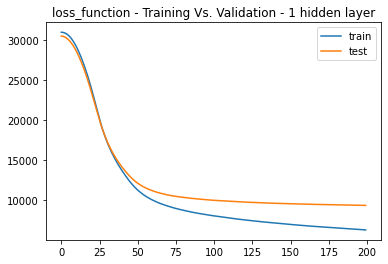

In [502]:
# Train vs test for shallow net
plt.plot(nn_model.history["loss"])
plt.plot(nn_model.history["val_loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
plt.legend(["train", "test"])
plt.show()

In [503]:
# first we need to define the number of hidden nodes and input features
# start with a shallow network and expand from there
# I am going to start with the number of columns as the input features
number_input_columns_2 = X.shape[1]
number_hidden_nodes_2 = (X.shape[1]/2)
hidden_layer_3 = (number_hidden_nodes_2/2)
hidden_layer_4 = (hidden_layer_3/2)

# Create NN
neural_network_2 = Sequential()

# create the hidden latter
neural_network_2.add(Dense(units = number_hidden_nodes, input_dim = number_input_columns, activation = "relu", kernel_initializer='normal' ))
# create output layer
neural_network_2.add(Dense(units = number_hidden_nodes_2,  activation = "relu", kernel_initializer='normal'))
# hidden layer 3
neural_network_2.add(Dense(units = hidden_layer_3,  activation = "relu", kernel_initializer='normal'))
# hidden layer 4
neural_network_2.add(Dense(units = hidden_layer_4,  activation = "relu", kernel_initializer='normal'))
#output layer
neural_network_2.add(Dense(units = 1,  activation = "linear", kernel_initializer='normal'))

In [504]:
neural_network_2.compile(loss="mean_absolute_error", optimizer="adam", metrics=["mean_absolute_error"])
neural_network_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 210)               88410     
_________________________________________________________________
dense_6 (Dense)              (None, 210)               44310     
_________________________________________________________________
dense_7 (Dense)              (None, 105)               22155     
_________________________________________________________________
dense_8 (Dense)              (None, 52)                5512      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 53        
Total params: 160,440
Trainable params: 160,440
Non-trainable params: 0
_________________________________________________________________


In [505]:
nn_model_2 = neural_network_2.fit(X_train_scaled, y_train,validation_split=0.3, epochs=200)

Epoch 1/200
50/50 [==============================] - 1s 5ms/step - loss: 30784.0332 - mean_absolute_error: 30784.0332 - val_loss: 29367.4629 - val_mean_absolute_error: 29367.4629
Epoch 2/200
50/50 [==============================] - 0s 4ms/step - loss: 19407.6699 - mean_absolute_error: 19407.6699 - val_loss: 10681.3135 - val_mean_absolute_error: 10681.3135
Epoch 3/200
50/50 [==============================] - 0s 3ms/step - loss: 9203.9512 - mean_absolute_error: 9203.9512 - val_loss: 9665.9170 - val_mean_absolute_error: 9665.9170
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 7869.9878 - mean_absolute_error: 7869.9878 - val_loss: 9366.8945 - val_mean_absolute_error: 9366.8945
Epoch 5/200
50/50 [==============================] - 0s 3ms/step - loss: 7169.1743 - mean_absolute_error: 7169.1743 - val_loss: 9083.8760 - val_mean_absolute_error: 9083.8760
Epoch 6/200
50/50 [==============================] - 0s 3ms/step - loss: 6623.3120 - mean_absolute_error: 6623.3120 -

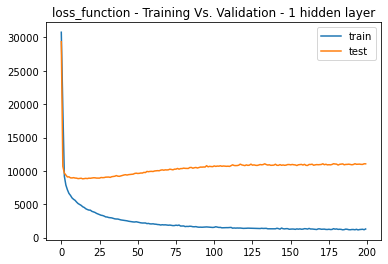

In [506]:
# Train vs test for shallow net
plt.plot(nn_model_2.history["loss"])
plt.plot(nn_model_2.history["val_loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
plt.legend(["train", "test"])
plt.show()